In [1]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
def plot_image(test_image,hard_pred_ori,mask_Fuse):
    # original image, UniverSeg, Ours
    plt.figure(figsize = (10,5))
    plt.subplot(1,3,1)
    plt.imshow(test_image.permute(0,2,3,1)[0])
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(test_image.permute(0,2,3,1)[0])
    show_mask(hard_pred_ori[0,0,:], plt.gca())
    plt.title('Universeg\'s Prediction')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(test_image.permute(0,2,3,1)[0])
    show_mask(mask_Fuse, plt.gca())
    plt.title(' ICL-SAM Prediction')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
def compute_iou(pred_mask, gt_mask):
    pred_mask = pred_mask.astype(bool)
    gt_mask = gt_mask.astype(bool)

    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()

    if union == 0:
        return float(intersection == 0)
    return intersection / union


In [2]:
import torch
from torch.nn import functional as F

import os
import cv2
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from utils.UniSeg_SAM import *

c:\Users\Lenovo\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
c:\Users\Lenovo\anaconda3\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
d:\Summer_internship\Visual Context Learning for remote sensing image processing\segment_anything\modeling\tiny_vit_sam.py:653: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered 

In [3]:
# Set the checkpoint path first
# SAM_Checkpoint = '/userhome/jiesi/dataset/MedSAM/medsam_vit_b.pth'
SAM_Checkpoint = './checkpoints/sam_vit_b_01ec64.pth'

### Load data

In [4]:
ref_folder = './data/fg/support/image/' # Path of support set
inf_folder = './data/fg/query/image/' # Path of query set

In [5]:
# Support Set
ref_image_paths = sorted(os.listdir(ref_folder))
ref_image_paths = [os.path.join(ref_folder,i) for i in ref_image_paths if '.png' in i]
print('Total length of support set:',len(ref_image_paths))

support_mask_list, support_image_list = [], []
for test_image_path in ref_image_paths:
    test_mask_path = test_image_path.replace('/image/','/mask/')
    
    test_image = cv2.imread(test_image_path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    test_mask = cv2.imread(test_mask_path)
    test_mask = cv2.cvtColor(test_mask, cv2.COLOR_BGR2RGB)
    
    test_mask = test_mask[:,:,0].astype('float')[None,None,:,:].clip(0,1)
    test_image = test_image.transpose(2,0,1)[None,:]
    
    support_mask_list.append(torch.tensor(test_mask))
    support_image_list.append(torch.tensor(test_image))

Total length of support set: 1


In [6]:
# Query set
inf_image_paths = sorted(os.listdir(inf_folder))
inf_image_paths = [os.path.join(inf_folder,i) for i in inf_image_paths if '.png' in i]
print('Total length of query set:',len(inf_image_paths))

Total length of query set: 5


### Load the model

In [7]:
# Load the model
Context_size = len(support_mask_list) 
alpha = 0.3*np.exp(-Context_size*0.1) 
beta = 2.0 
gamma = 0 # Weight for UniverSeg in mask fusion module
print('Context_size:',Context_size,'alpha:',alpha,'beta:',beta,'gamma:',gamma)

predictor = UniSAM_predictor(alpha,
                            beta,
                            gamma,
                            Context_size,
                            checkpoint = SAM_Checkpoint)

Context_size: 1 alpha: 0.27145122541078787 beta: 2.0 gamma: 0
sam.MedSAM_norm: False


In [8]:
predictor.set_support_images_bg(
        support_image_list,
        support_mask_list,
        )
predictor.set_support_images_fg(
        support_image_list,
        support_mask_list,
        )

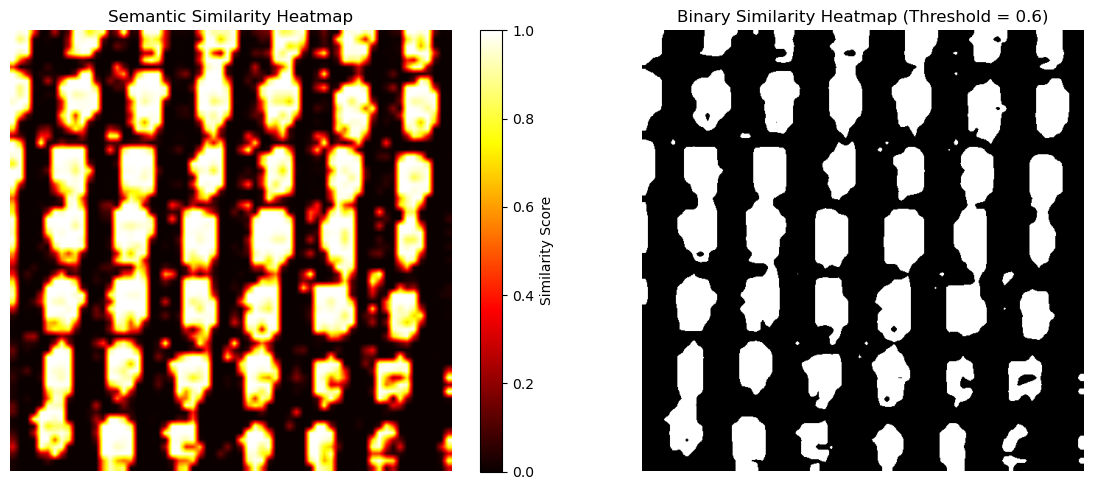

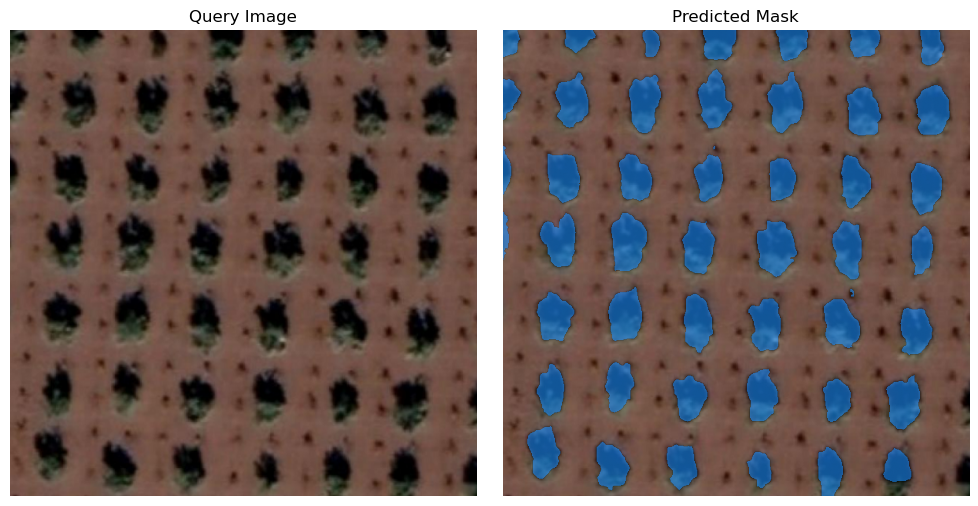

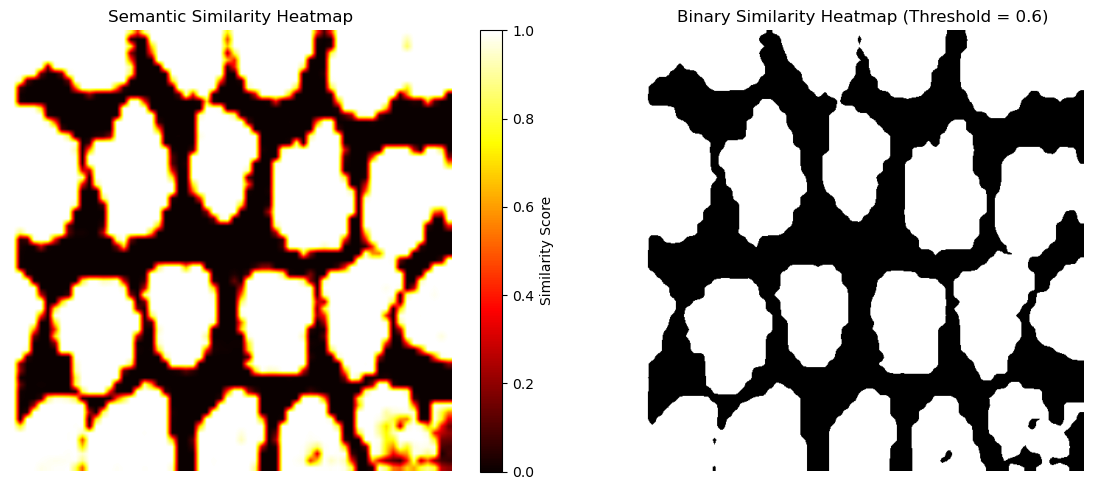

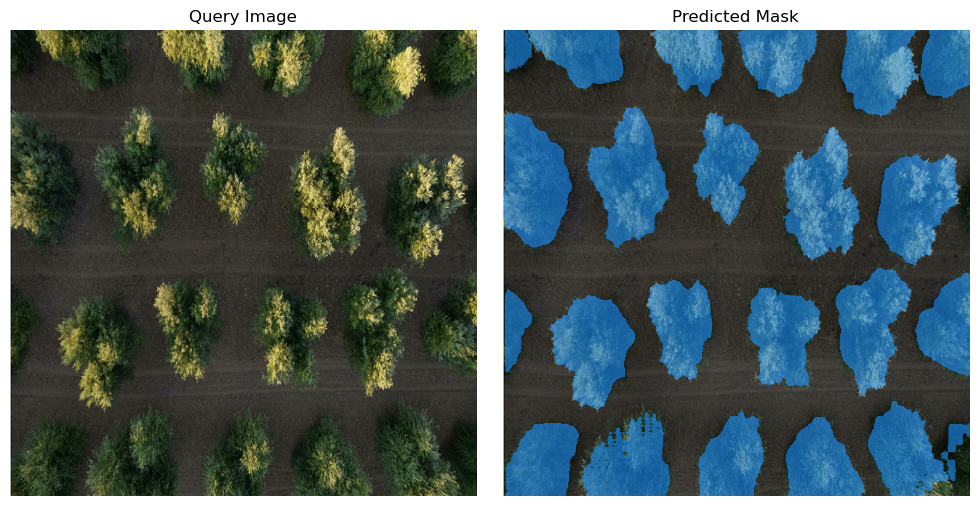

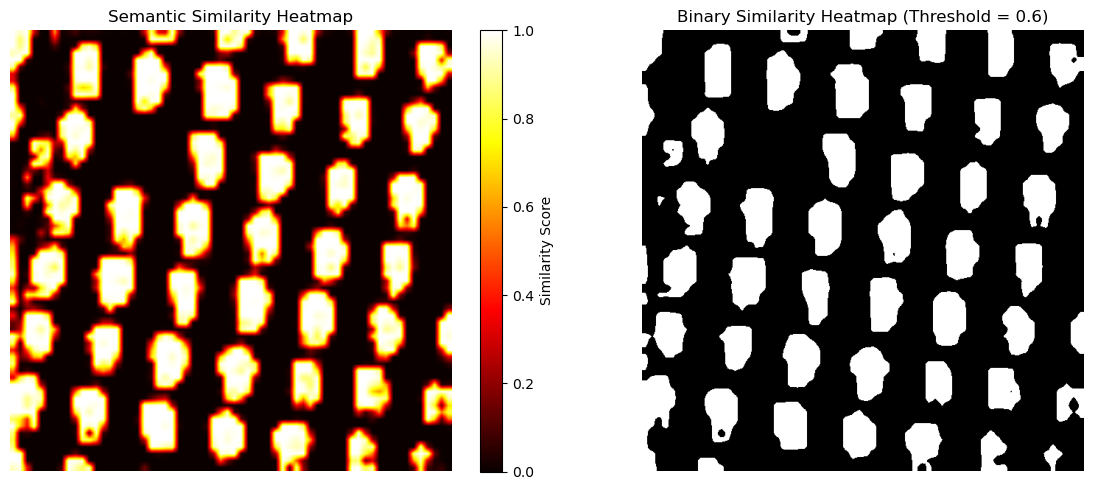

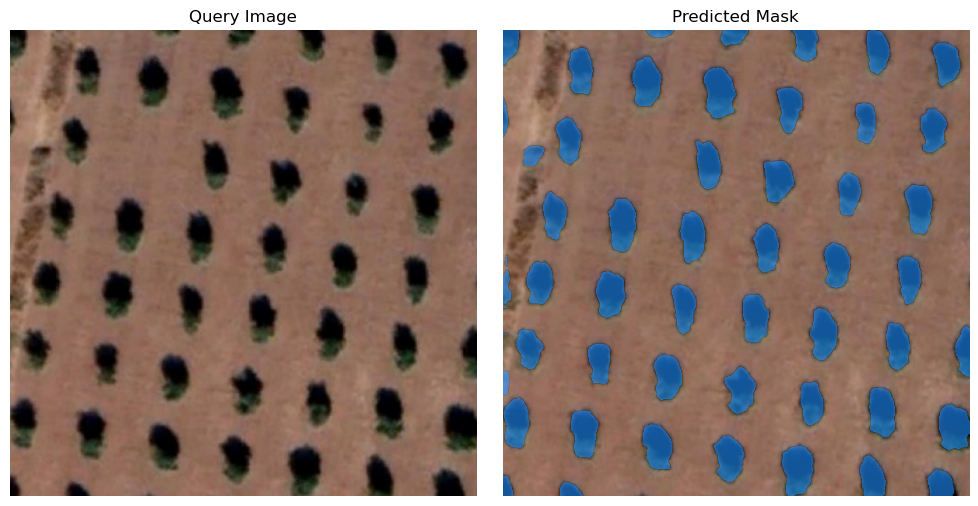

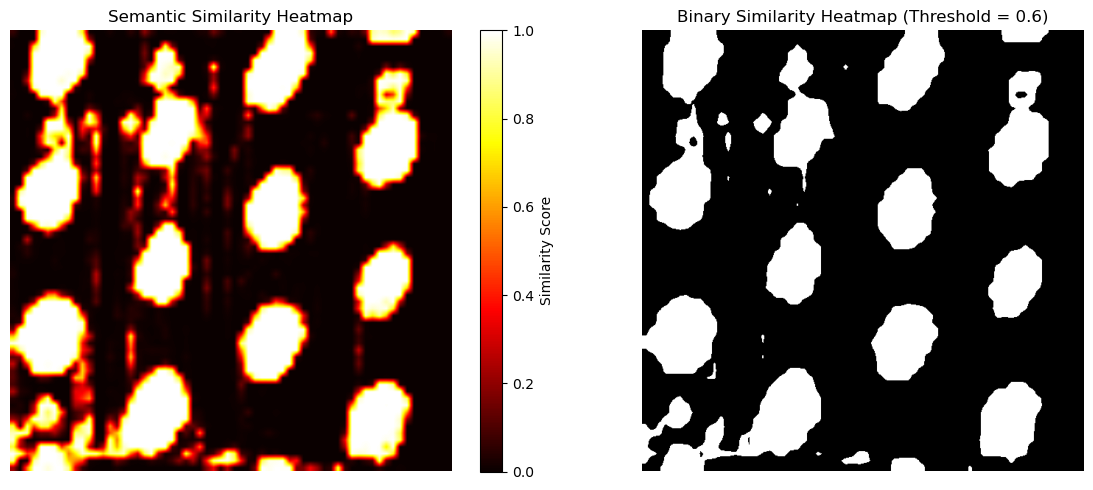

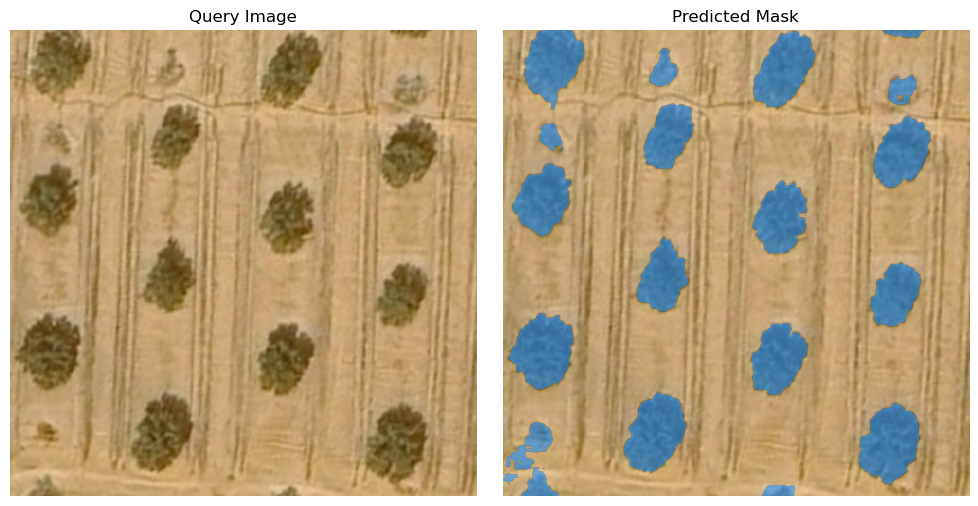

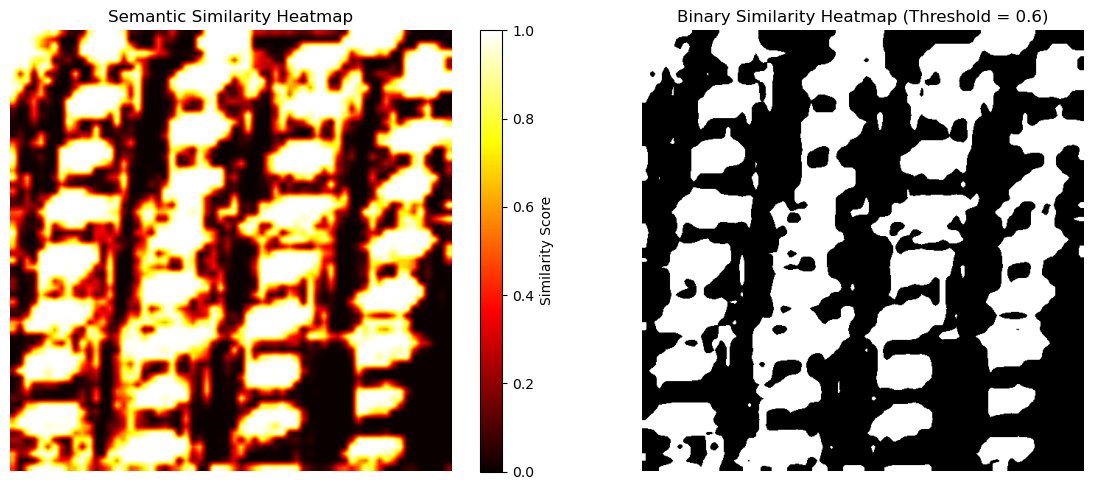

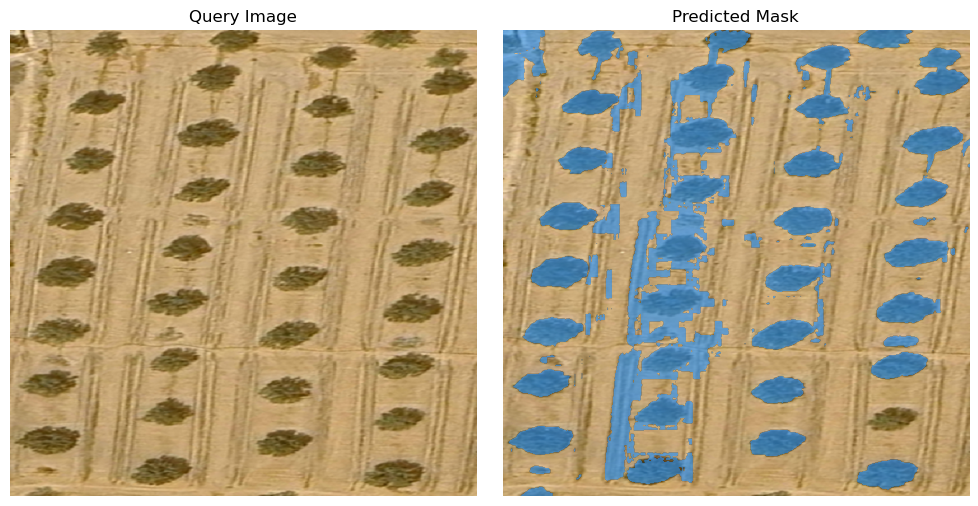

In [9]:
import torch
from torch.nn import functional as F
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])  # Light blue with alpha
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


# Inference loop 
for test_image_path in inf_image_paths:
    # Load and prepare image
    test_image = cv2.imread(test_image_path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    test_image_tensor = torch.tensor(test_image.transpose(2, 0, 1)[None, :])  # Shape: (1, 3, H, W)

    # Predict mask
    mask = predictor.predict(test_image_tensor)

    # Show image and prediction (styled)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(test_image)
    plt.title('Query Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(test_image)
    show_mask(mask, plt.gca())
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Convert mask_Fuse to tensor if it's NumPy
    if isinstance(mask, np.ndarray):
        mask_tensor = torch.tensor(mask).float()
    else:
        mask_tensor = mask.float()

    mask_tensor = mask_tensor.unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)

    # Resize prediction
    pred_mask_np = F.interpolate(mask_tensor, size=test_image.shape[:2], mode='bilinear', align_corners=False)
    pred_mask_np = pred_mask_np[0, 0].detach().cpu().numpy()

    # Binarize prediction
    pred_mask_bin = (pred_mask_np > 0.5).astype(np.uint8)


#### Comparison with other models

In [10]:
predictor.set_support_images(
        support_image_list,
        support_mask_list,
        )


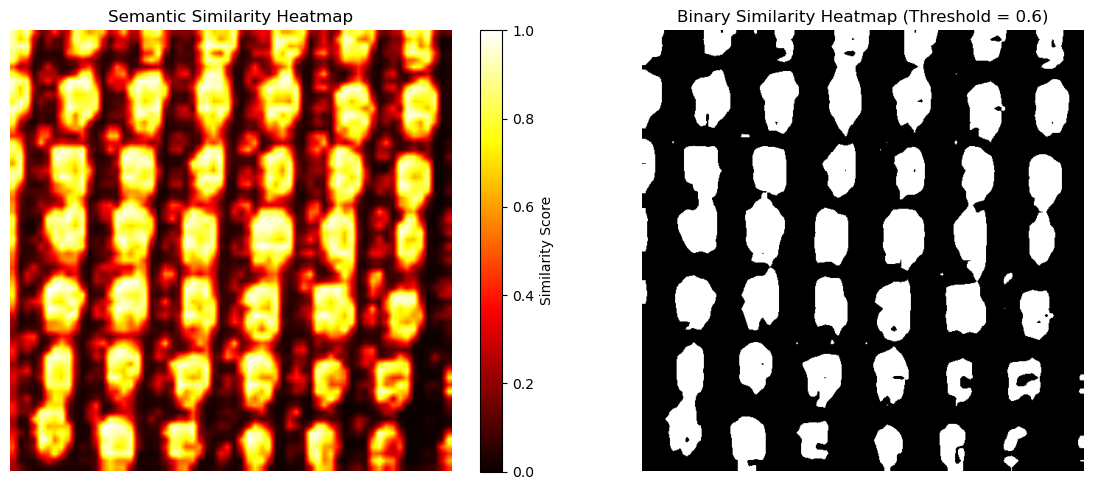

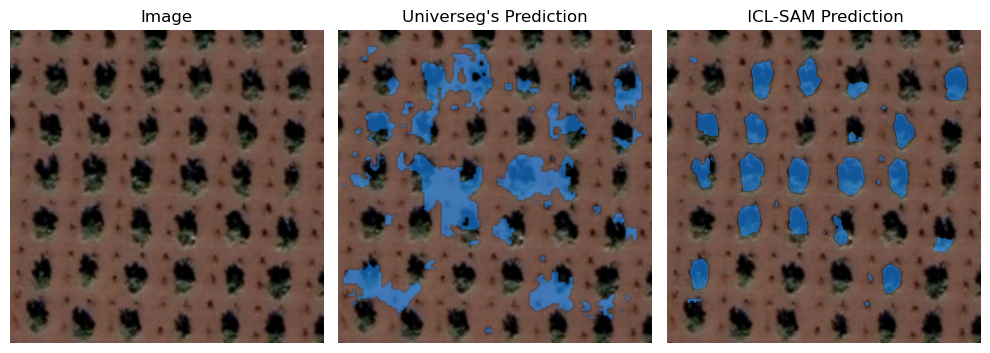

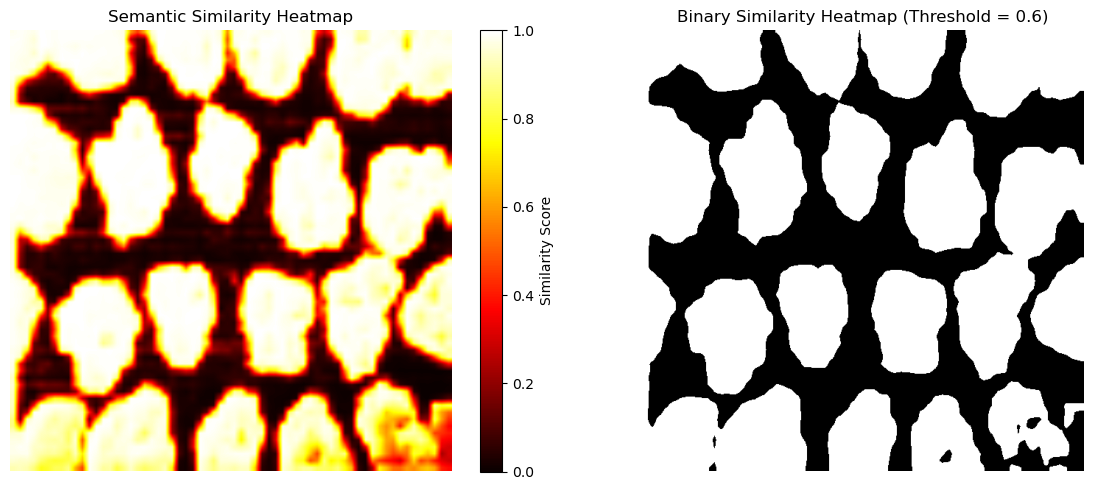

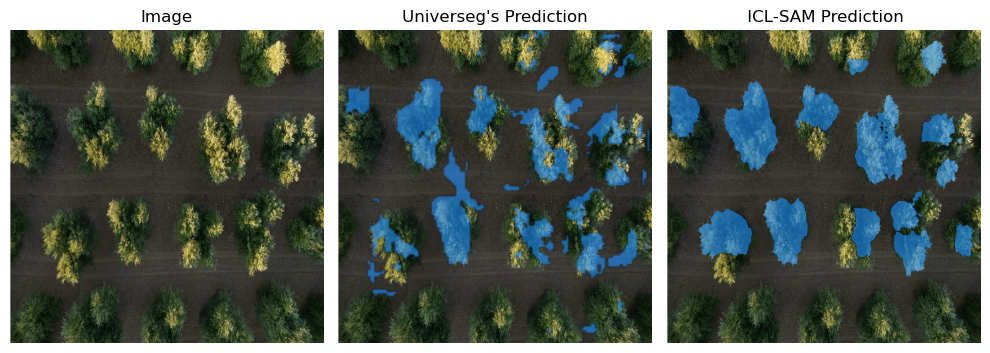

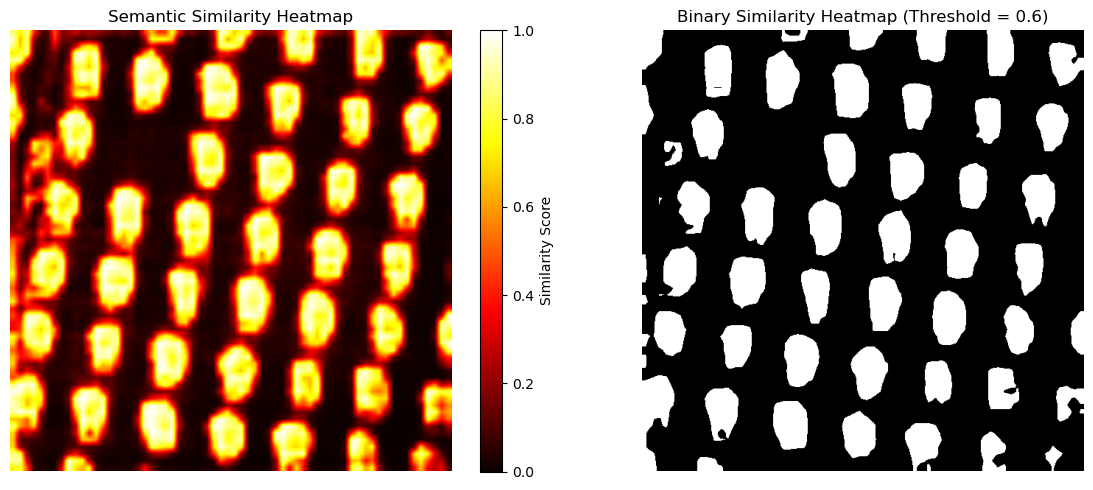

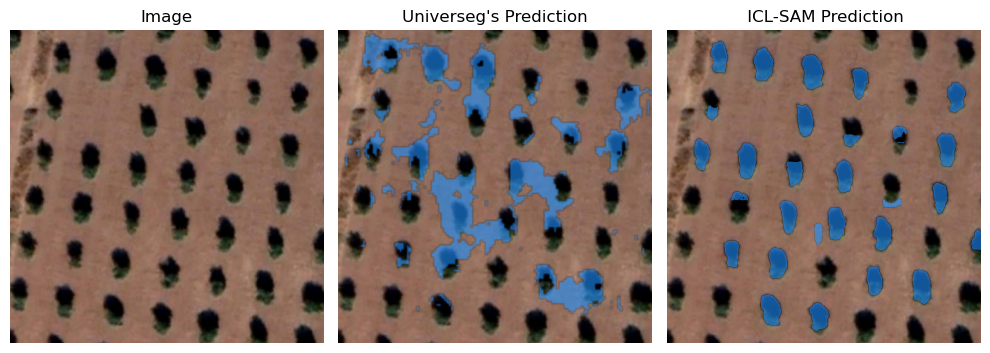

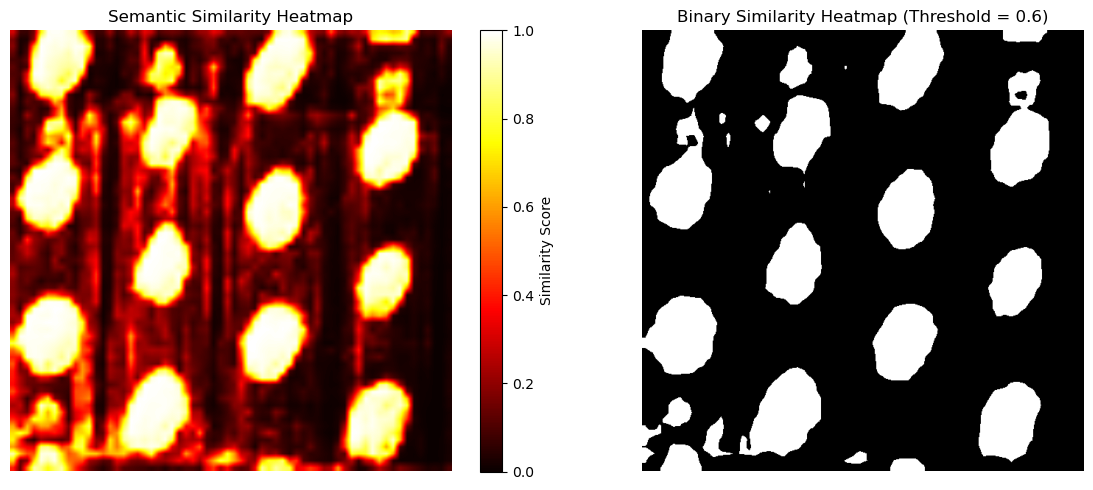

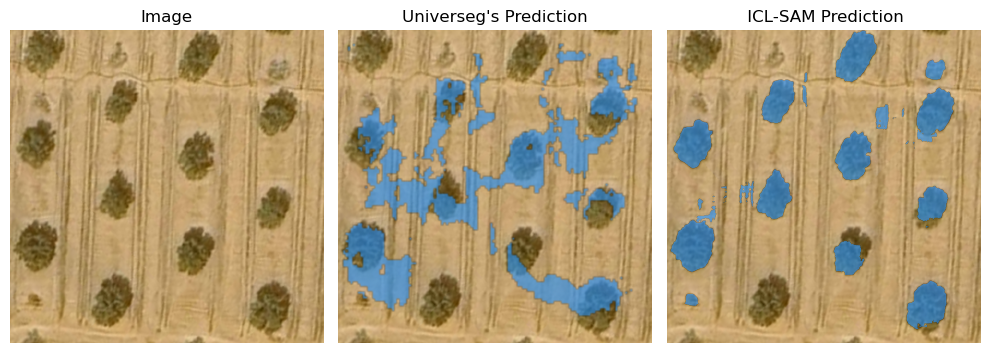

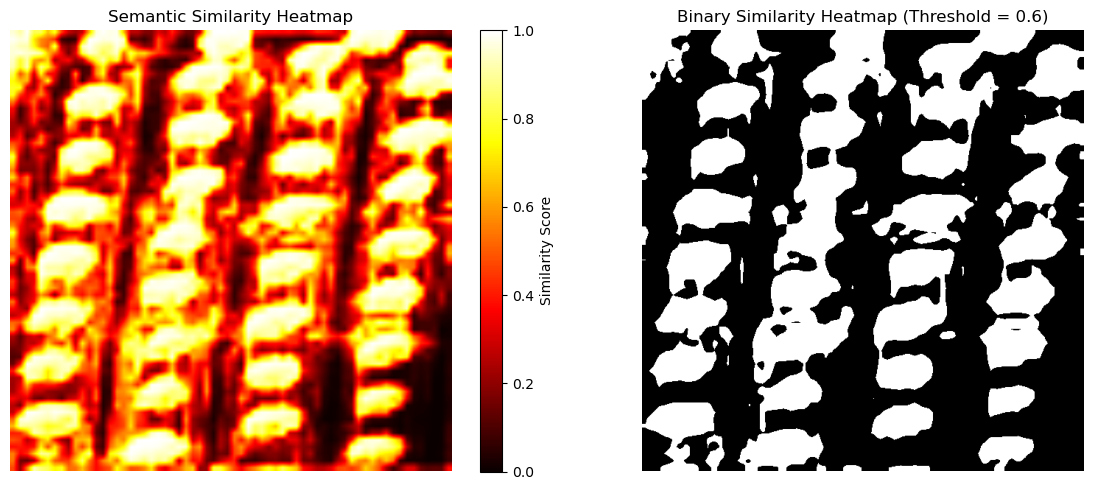

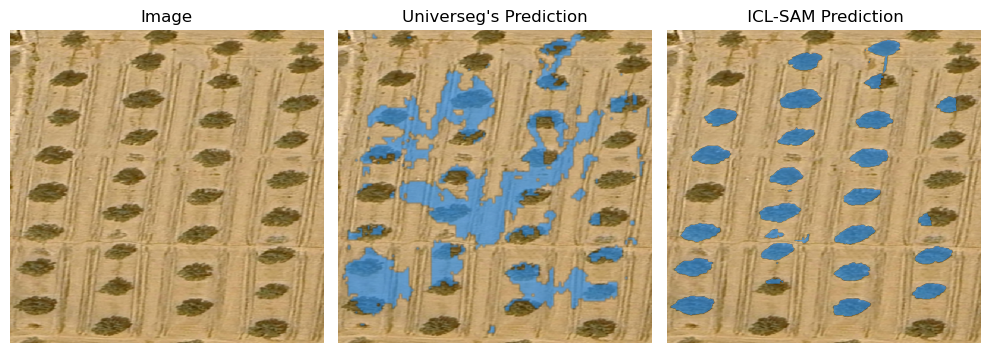

In [11]:
for i in inf_image_paths:
    test_image_path  = i
    test_image = cv2.imread(test_image_path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    test_image = test_image.transpose(2,0,1)[None,:]
    test_image = torch.tensor(test_image)
    hard_pred_ori, _, _, mask_Fuse = predictor.predict_detailed(test_image)
    plot_image(test_image,hard_pred_ori,mask_Fuse)